In [23]:

import pandas as pd
import os
import gseapy as gp
import sklearn
sklearn.set_config(transform_output="pandas")
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
import numpy as np
import requests
import harmonypy as hm
from inmoose.pycombat import pycombat_norm, pycombat_seq
import matplotlib.pyplot as plt
import math, re
from scipy.stats import levene
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, accuracy_score, classification_report

from sklearn.neighbors import NearestNeighbors
from scipy.stats import gmean
import gseapy as gp
from TMEImmune import TME_score
from tidepy.pred import TIDE
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy.stats import fisher_exact, mannwhitneyu, spearmanr
import matplotlib.font_manager as fm
import seaborn as sns
import category_encoders as ce
from statannotations.Annotator import Annotator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
from matplotlib_venn import venn2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

#### useful functions

In [ ]:
def compute_entropy(data_expression_df, labels):
    """ Compute the mean entropy of the given gene expression matrix. """
    nbrs = NearestNeighbors(n_neighbors = 10, metric="euclidean").fit(
        data_expression_df.T
    )
    _, indices = nbrs.kneighbors(data_expression_df.T)
    batch_labels = labels

    entropies = []
    for index in indices:
        neighbors_labels = batch_labels[index]
        label_counts = np.unique(neighbors_labels, return_counts=True)[1]
        probabilities = label_counts / len(neighbors_labels)
        entropy = -np.sum(probabilities * np.log2(probabilities))
        entropies.append(entropy)

    return np.mean(entropies)

def batch_correction(df, batch, method = "combat", batch_name = None): # batch correction for ComBat or Harmony
    if method == "combat":
        df_corrected = pycombat_norm(df, batch)
    else:  ## harmony
        if batch_name is None: 
            ho = hm.run_harmony(df, pd.DataFrame(batch), [0])
        else:
            ho = hm.run_harmony(df, pd.DataFrame(batch), [batch_name])
        df_corrected = pd.DataFrame(ho.Z_corr, columns = df.columns, index = df.index)
    return df_corrected

def fit_coxph(score, event = "os_event", time = "os_months",name = None, merge_type = None,
              tcga = False, tcga_source = None): 
    """ fit coxph model for merged cohorts """
    score_cols = ['CYT1', 'CYT2', 'IFNr','TLS', 'TIS','TIP Hot','TIP Cold', 'CS Polarity','IMPRES','TGFb', 'IS_immune', 'IS_stromal',
                'NetBio', 'SIA', 'TIDE', 'B_cells', 'CD8Treg']
    if not tcga:
        full_df1 = score.dropna(subset=[event,time, 'gender', 'age'])
        # binary encoding
        full_df1['gender1'] = full_df1['gender'].apply(lambda x: 1 if x == "M" else 0)
        full_df1['treatment1'] = full_df1['treatment'].apply(lambda x: 1 if x == "pd1/pdl1" else 0)
        columns = ['source', 'cancer'] # other categorical variables
        full_df1 = full_df1.rename(columns = {"tumor type": "tumor_type"})
        cat_cols = [c for c in columns if full_df1[c].dropna().nunique() > 1] # drop if only one level
        single_level_col = set(columns) - set(cat_cols)
        
        if single_level_col:
            print(f"{name} : {single_level_col} are dropped because they only have one level")
        # frequency encoding
        encoder = ce.CountEncoder(cols=cat_cols) 
        encoder.fit(full_df1[cat_cols], full_df1[event])
        var_df = encoder.transform(full_df1[cat_cols])

        # scale all variables to [0,1]
        scaler = MinMaxScaler(feature_range=(0,1))
        var_df = scaler.fit_transform(var_df)
        cols = score_cols + [event, time, 'age', 'gender1', 'treatment1']
        full_df2 = pd.concat([var_df, full_df1[cols]], axis = 1, join = "inner")
        full_df2[event] = full_df2[event].astype(int)
        full_df2['age'] = full_df2['age'].astype(int)
    else:
        full_df1 = score.dropna(subset=[time, event, 'age', 'gender', tcga_source])
        # binary encoding
        full_df1['gender1'] = full_df1['gender'].apply(lambda x: 1 if x == "male" else 0)
        columns = [tcga_source]
        # frequency encoding
        encoder = ce.CountEncoder(cols=columns) 
        encoder.fit(full_df1[columns], full_df1[event])
        var_df = encoder.transform(full_df1[columns])
        cols = score_cols + [event, time, 'age', 'gender1']
        full_df2 = pd.concat([var_df, full_df1[cols]], axis = 1, join = "inner")
        full_df2[event] = full_df2[event].astype(int)
        full_df2['age'] = full_df2['age'].astype(int)
    cox_models = {}
    cindex = {}
    best_cindex = 0
    for col in score_cols:
        full_df3 = full_df2.drop(columns = [s for s in score_cols if s != col])
        # remove NaN and infinite values
        full_df3 = full_df3[~full_df3[col].isna()]
        full_df3 = full_df3[np.isfinite(full_df3[col])]
        if merge_type: ## multivariate coxph
            cph = CoxPHFitter(penalizer=1e-4, l1_ratio = 0.9, alpha = 0.1)
            cph.fit(full_df3, 
                duration_col=time, event_col=event, show_progress=False)
        else: ## univariate coxph
            cph = CoxPHFitter(penalizer=1e-4, l1_ratio = 0.9, alpha = 0.1)
            cph.fit(full_df3[[event, time, col]], duration_col = time, event_col = event, show_progress = False)

        cox_models[col] = cph
        cindex[col] = cph.concordance_index_
        if cph.concordance_index_ > best_cindex:
            best_cindex = cph.concordance_index_
    keys = [k for k, v in cindex.items() if v == best_cindex]
    vals = np.array(list(cindex.values()))
    var_pop = np.var(vals)  ## variance of the c-index
    print(f"{name} : {keys} have the highest c-index in coxph, the best c-index = {best_cindex:.4f}, variance = {var_pop:.4f}")
    return cox_models, cindex, var_pop

def extract_cox_summary(cox_df, cindex, form = "multivariate"):
    """ Extract summary table from coxph model """
    all_tables = {}
    score_cols = ['CYT1', 'CYT2', 'IFNr','TLS', 'TIS','TIP Hot','TIP Cold', 'CS Polarity','IMPRES','TGFb', 'IS_immune', 'IS_stromal',
                'NetBio', 'SIA', 'TIDE', 'B_cells', 'CD8Treg']
    for score in score_cols:
        summary_table = cox_df[score].summary
        summary_table['score'] = score
        summary_table['c-index'] = cindex
        summary_table['regression'] = form
        all_tables[score] = summary_table
    all_tables_df = pd.concat(all_tables, axis = 0)
    return all_tables_df

def remove_outlier(df, identical = False):
    """ Remove outliers from the dataframe using IQR method. If identical is True, 
    it will also remove outliers based on rounding to 3 decimal places for specific columns. """
    df1 = df.copy()
    for col in df1.columns:
        df1[col] = df1[col].astype(float)
        Q3 = df1[col].quantile(0.75)
        Q1 = df1[col].quantile(0.25)
        IQR = Q3 - Q1
        upper = Q3 + 1.5 * IQR
        lower = Q1 - 1.5* IQR
        outlier_mask = (df1[col] >= upper) | (df1[col] <= lower)
        df1.loc[outlier_mask, col] = None
        removed = outlier_mask.sum()
        if identical:
            if col in ['TLS', 'IFNr']:
                rounded = df1.copy()
                name = "round_"+col
                rounded[name] = rounded[col].round(3)
                filtered = rounded.drop_duplicates(subset=[name])
                filtered = filtered.drop(columns=[name])
                samples = list(set(rounded.index) - set(filtered.index))
                df1.loc[samples, col] = None
                removed += rounded.shape[0] - filtered.shape[0]
        print(f"{removed} outliers detected for {col}")
    return df1

def preprocess(df):
    """ Transform min-max scaled array to pandas dataframe"""
    df1 = remove_outlier(df)
    rows = df1.index
    cols = df1.columns
    scaler = MinMaxScaler(feature_range=(0, 1))
    df2 = pd.DataFrame(scaler.fit_transform(df1), index = rows, columns = cols)
    return df2

score_cols = ['CYT1', 'CYT2', 'IFNr','TLS', 'TIS', 'TIP Hot','TIP Cold', 'CS Polarity','IMPRES','TGFb', 'IS_immune', 'IS_stromal',
                'NetBio', 'SIA', 'TIDE', 'B_cells', 'CD8Treg']
def divide_group(df, score_list = score_cols, half = False):
    """ Divide scores into groups based on quantiles or median."""
    for score in score_list:
        score_group = score + "_group"
        if half:
            q_m = df[score].median()
            df[score_group] = "L"
            df.loc[df[score] > q_m, score_group] = "H"

        else:
            q_low, q_high = df[score].quantile([0.25, 0.75])
            df[score_group] = 'M'
            df.loc[df[score] <= q_low, score_group] = 'L'
            df.loc[df[score] >= q_high, score_group] = 'H'
    return df

##### read data

In [ ]:
### load clinical data
full_clin = pd.read_excel("data/clinical.xlsx", sheet_name = 0, index_col=0)
tcga_os_clin = pd.read_excel("data/clinical.xlsx", sheet_name = 1, index_col=0)
vath_clin = pd.read_excel("data/clinical.xlsx", sheet_name = 2, index_col=0)
ravi_clin = pd.read_excel("data/clinical.xlsx", sheet_name = 3, index_col=0)
foy_nsclc_clin = pd.read_excel("data/clinical.xlsx", sheet_name = 4, index_col=0)
foy_hnscc_clin = pd.read_excel("data/clinical.xlsx", sheet_name = 5, index_col=0)


### load scores and preprocess
combined_score = pd.read_excel("data/all_scores.xlsx", sheet_name = 0, index_col = 0)
combined_score = preprocess(combined_score)
melanoma_score = pd.read_excel("data/all_scores.xlsx", sheet_name = 1, index_col = 0)
melanoma_score = preprocess(melanoma_score)
ccrcc_score = pd.read_excel("data/all_scores.xlsx", sheet_name = 'ccRCC', index_col = 0)
ccrcc_score = preprocess(ccrcc_score)
urothelial_met_score = pd.read_excel("data/all_scores.xlsx", sheet_name = 'UC-II', index_col=0)
urothelial_met_score = preprocess(urothelial_met_score)
unc108_score = pd.read_excel("data/all_scores.xlsx", sheet_name = 'UNC-108', index_col=0)
unc108_score = preprocess(unc108_score)
vath_score = pd.read_excel("data/all_scores.xlsx", sheet_name = 'MELANOMA-II', index_col=0)
vath_score = preprocess(vath_score)
foy_nsclc_score = pd.read_excel("data/all_scores.xlsx", sheet_name = 'NIVOBIO', index_col=0)
foy_nsclc_score = preprocess(foy_nsclc_score)
foy_hnscc_score = pd.read_excel("data/all_scores.xlsx", sheet_name = 'CLB-IHN', index_col=0)
foy_hnscc_score = preprocess(foy_hnscc_score)
ravi_score = pd.read_excel("data/all_scores.xlsx", sheet_name = 'NSCLC-II', index_col=0)
ravi_score = preprocess(ravi_score)
tcga_os_score = pd.read_excel("data/all_scores.xlsx", sheet_name = 'TCGA', index_col = 0)
tcga_os_score = preprocess(tcga_os_score)

In [ ]:
###  merged score and clinical data

combined_data = combined_score.merge(full_clin, left_index = True, right_index = True, how = "inner")
melanoma_data = melanoma_score.merge(full_clin, left_index = True, right_index = True, how = "inner")
combined_data1 = divide_group(combined_data)
melanoma_data1 = divide_group(melanoma_data)

vath_data = vath_score.merge(vath_clin, left_index = True, right_index = True, how = "inner")
ccrcc_data = ccrcc_score.merge(full_clin, left_index = True, right_index = True, how = "inner")
unc108_data = unc108_score.merge(full_clin, left_index = True, right_index = True, how = "inner")
urothelial_met_data = urothelial_met_score.merge(full_clin, left_index = True, right_index = True, how = "inner")
foy_nsclc_data = foy_nsclc_score.merge(foy_nsclc_clin, left_index = True, right_index = True, how = "inner")
ravi_data = ravi_score.merge(ravi_clin, left_index = True, right_index = True, how = "inner")
foy_hnscc_data = foy_hnscc_score.merge(foy_hnscc_clin, left_index = True, right_index = True, how = "inner")


## divide patients into groups based on scores
vath_data1 = divide_group(vath_data)
ccrcc_data1 = divide_group(ccrcc_data)
unc108_data1 = divide_group(unc108_data)
urothelial_met_data1 = divide_group(urothelial_met_data)
foy_nsclc_data1 = divide_group(foy_nsclc_data)
ravi_data1 = divide_group(ravi_data)
foy_hnscc_data1 = divide_group(foy_hnscc_data)

tcga_os_data = tcga_os_score.merge(tcga_os_clin, left_index = True, right_index = True, how = "inner")
tcga_os_data1 = divide_group(tcga_os_data)

#### Cox-PH

In [ ]:
#### multivariate coxph

cox_combined, cindex_combined, cindex_combined_var = fit_coxph(combined_data1, 
                                                               name = "COM-ICI", merge_type="cancer") # use model[score].summary to get the coef
cox_melanoma, cindex_melanoma, cindex_melanoma_var = fit_coxph(melanoma_data1, 
                                                               name = "MELANOMA-I", merge_type="treatment")


cox_tcga_os, cindex_tcga_os, cindex_tcga_os_var = fit_coxph(tcga_os_data1,
                                                            name = "TCGA", 
                                                            merge_type="tumor_type", tcga = True, tcga_source = "cancer")

#### univariate coxph

cox_combined_uni, cindex_combined_uni, cindex_combined_uni_var = fit_coxph(combined_data1, name = "COM-ICI") 
cox_melanoma_uni, cindex_melanoma_uni, cindex_melanoma_uni_var = fit_coxph(melanoma_data1, name = "MELANOMA-I")
cox_tcga_os_uni, cindex_tcga_os_uni, cindex_tcga_os_var_uni = fit_coxph(tcga_os_data1, name = "COM-TCGA-I", tcga = True, tcga_source = "cancer")


#### results
cox_combined_multi = extract_cox_summary(cox_combined, cindex_combined)
cox_combined_uni1 = extract_cox_summary(cox_combined_uni, cindex_combined_uni, form = "univariate")
cox_combined_df = pd.concat([cox_combined_multi, cox_combined_uni1], axis = 0)

cox_melanoma_multi = extract_cox_summary(cox_melanoma, cindex_melanoma)
cox_melanoma_uni1 = extract_cox_summary(cox_melanoma_uni, cindex_melanoma_uni, form = "univariate")
cox_melanoma_df = pd.concat([cox_melanoma_multi, cox_melanoma_uni1], axis = 0)

cox_tcga_os_multi = extract_cox_summary(cox_tcga_os, cindex_tcga_os)
cox_tcga_os_uni1 = extract_cox_summary(cox_tcga_os_uni, cindex_tcga_os_uni, form = "univariate")
cox_tcga_os_df = pd.concat([cox_tcga_os_multi, cox_tcga_os_uni1], axis = 0)

COM-ICI : ['CS Polarity'] have the highest c-index in coxph, the best c-index = 0.5807, variance = 0.0001
MELANOMA-I : {'cancer'} are dropped because they only have one level
MELANOMA-I : ['CYT2'] have the highest c-index in coxph, the best c-index = 0.6786, variance = 0.0003
TCGA : ['IS_immune'] have the highest c-index in coxph, the best c-index = 0.7101, variance = 0.0001
COM-ICI : ['TIS'] have the highest c-index in coxph, the best c-index = 0.5677, variance = 0.0004
MELANOMA-I : {'cancer'} are dropped because they only have one level
MELANOMA-I : ['TIDE'] have the highest c-index in coxph, the best c-index = 0.6248, variance = 0.0015
COM-TCGA-I : ['IFNr'] have the highest c-index in coxph, the best c-index = 0.5825, variance = 0.0011


#### Fig. 1 (AUC plots)

In [ ]:

def auc_plot(ax, df, name, resp_col = "resp", event_col = "os_event",
             show_sig = True, palette = "#1f77b4"):
    """ 
    Plot AUC for different scores in the dataframe. For merged cohorts, AUCs of all scores are calculated 
    based on the response column. For individual ICI-treated cohorts, only scores with AUC > 0.5 are shown.
    """
    aucs = {}
    score_cols = ['CYT1', 'CYT2', 'IFNr','TLS', 'TIS','TIP Hot','TIP Cold', 'CS Polarity','IMPRES','TGFb', 'IS_immune', 'IS_stromal',
                'NetBio', 'SIA', 'TIDE', 'B_cells', 'CD8Treg']
    for col in score_cols:
        df1 = df.dropna(subset = [col, resp_col])
        df1 = df1[np.isfinite(df1[col])]

        # reverse the sign for TIDE, IS_stromal, and TGFb scores
        if col in ['TIDE', 'IS_stromal', 'TGFb']:
            fpr, tpr, thresholds = roc_curve(
                df1[resp_col],
                -df1[col]
            )
        else:
            fpr, tpr, thresholds = roc_curve(
                df1[resp_col],
                df1[col]
            )

        aucs[col] = [auc(fpr, tpr)]

    auc_df = pd.DataFrame({"score": list(aucs.keys()), "AUC-ICI": [x[0] for x in aucs.values()]})
    auc_df_sorted = auc_df.sort_values("AUC-ICI", ascending=False).reset_index(drop=True)

    if show_sig: # only show scores with AUC > 0.5
        auc_df_sorted = auc_df_sorted[auc_df_sorted["AUC-ICI"] > 0.5]
        ax.bar(auc_df_sorted["score"], auc_df_sorted["AUC-ICI"], color = palette)
        ax.set_ylim(0.5,0.8)   
        ax.grid(True, alpha = 0.3)
    else:
        auc_df_melted = auc_df.melt(id_vars=['score'], value_vars = ['AUC-ICI'],#value_vars=['AUC-ICI', 'AUC-Survival'], 
                                    var_name='category', value_name='value')
        sns.barplot(data = auc_df_melted, x = 'score',
                    y = 'value',
                    hue = 'category', 
                    dodge= True, 
                    palette=palette, order = auc_df_sorted["score"],
                    ax = ax)
        ax.axhline(0.5, color="darkgrey", linestyle="--")
        ax.set_ylim(0,1)

    ax.set_xlabel("")
    ax.set_xticklabels(auc_df_sorted["score"], rotation=45, ha="right", fontsize=12, fontweight='bold')
    ax.set_ylabel("AUC", fontsize=12, fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, fontweight='bold')
    ax.set_title(name, fontsize=14, fontweight='bold')
    leg = ax.legend(frameon=False, title="", title_fontsize = 12,
                        prop={'weight':'bold', 'size':10}, loc = "upper right")
    leg.get_title().set_fontweight('bold')
    return ax


<Axes: title={'center': 'MELANOMA-I'}, ylabel='AUC'>

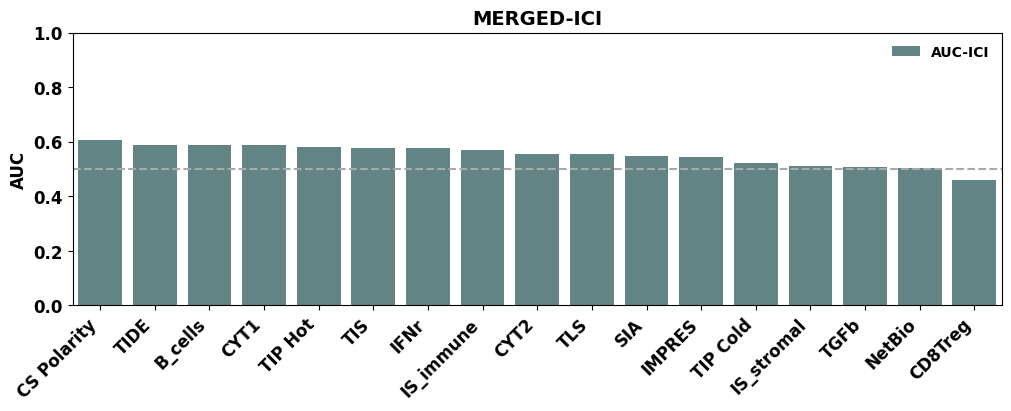

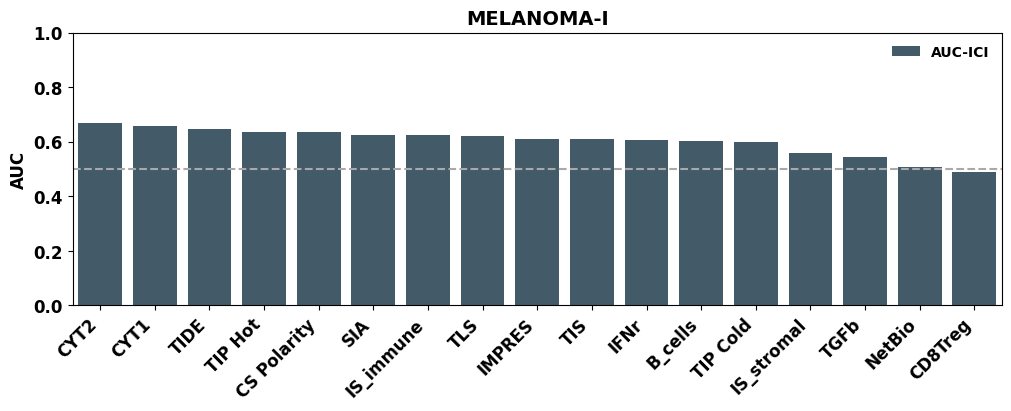

In [57]:
### merged cohorts AUC plot
fig1_1, ax1_1 = plt.subplots(figsize=(10, 4), constrained_layout=True)

auc_plot(ax1_1, combined_data1, name = "MERGED-ICI", 
                                       show_sig = False, palette=["#5C8A8A", "#A7C4C4"])

fig1_2, ax1_2 = plt.subplots(figsize=(10, 4), constrained_layout=True)
auc_plot(ax1_2, melanoma_data1, name = "MELANOMA-I", 
                                            show_sig=False, palette = ["#3D5C6F", "#9DAEB6"])


<Axes: title={'center': 'UC-II'}, ylabel='AUC'>

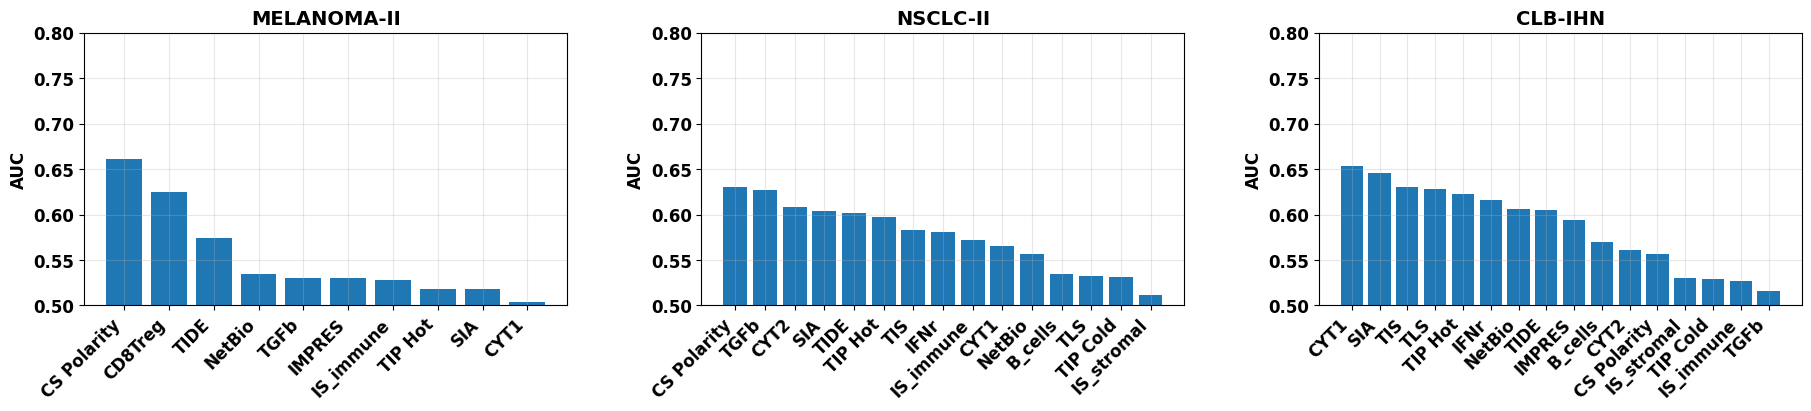

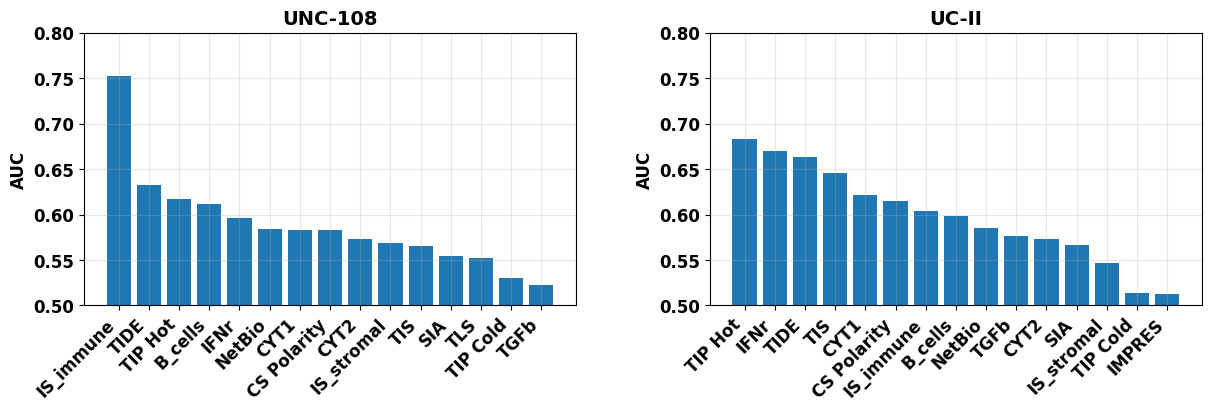

In [58]:
## Plot AUC for individual ICI-treated cohorts
fig1_3, ax1_3 = plt.subplots(1,3, figsize=(18, 4), constrained_layout=True, gridspec_kw={'wspace': 0.1})

auc_plot(ax1_3[0], df = vath_data, event_col = "os_status", name = "MELANOMA-II")
auc_plot(ax1_3[1], df = ravi_data1, name = "NSCLC-II")
auc_plot(ax1_3[2], df = foy_hnscc_data1, event_col = "OS_status", name = "CLB-IHN")

fig1_4, ax1_4 = plt.subplots(1,2, figsize=(12, 4), constrained_layout=True, gridspec_kw={'wspace': 0.1})
unc108_data2 = unc108_data1.fillna(0)
auc_plot(ax1_4[0], df = unc108_data2, name = "UNC-108")
auc_plot(ax1_4[1], df = urothelial_met_data1, name = "UC-II")

#### Fig 2 (Boxplots for merged cohorts, 2 volcano plots)

In [ ]:

def mwu_test(df, score_list, resp_col = "resp"):
    """ Perform Mann-Whitney U test for each score in the score_list against the response column."""
    results = []
    for score in score_list:
        df1 = df.dropna(subset = score)
        r  = df1.loc[df1[resp_col]==1, score]
        nr = df1.loc[df1[resp_col]==0,score]
        U, p = stats.mannwhitneyu(r, nr, alternative='two-sided')
        rho, _ = spearmanr(df1[score], df1[resp_col])
        results.append({'score':score, 'U_stat':U, 'p_value':p, 'rho': rho})

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('p_value').reset_index(drop=True)
    return results_df

def p_to_stars(p):
    if p < 0.001: return "****"
    if p < 0.01:  return "***"
    if p < 0.05:  return "**"
    if p < 0.1:   return "*"
    return "ns"


def box_resp(ax, df, scores, name, resp_col = "resp", col_palette = {"R": "#8BCBF1", "NR": "#498AC7"}):
    """ 
    Boxplots to compare the distribution of scores in responders vs non-responders
    """
    
    #fig, ax = plt.subplots(figsize = (len(scores)*1.5, 6))
    x = "score"
    y = "value"
    hue = "response"
    hue_order = ["R", "NR"]

    results_df = mwu_test(df, scores, resp_col)
    results_df = results_df.sort_values('p_value').reset_index(drop=True)
    order = results_df['score'].tolist()

    df1 = df.assign(response = df[resp_col].map({1:'R',0:'NR'})).melt(id_vars=['response'], 
            value_vars=scores,
            var_name='score', value_name='value')
    
    sns.boxplot(ax = ax, x=x, y=y, hue = hue, hue_order = hue_order, order = order, data=df1, fill = True, palette = col_palette, 
                showfliers = False)
    
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title="response")

    ## add significance brackets
    box_width = 0.2       
    vertical_offset = 0.01 
    for idx, row in results_df.iterrows():

        score = row["score"]
        pval  = row["p_value"]
        stars = p_to_stars(pval)

        # Find the numeric x‐position of this category
        cat_idx = order.index(score)

        # Compute the group’s maximum y‐value
        group_max = df1.loc[df1[x] == score, y].max()

        # Set bracket’s vertical coords
        base_y     = group_max + vertical_offset
        leg_height = vertical_offset / 2
        star_y     = base_y + leg_height + 0.005

        # Compute left/right x‐coords for “R” vs “NR”
        x1 = cat_idx - box_width/2
        x2 = cat_idx + box_width/2

        # Draw the bracket
        ax.plot(
            [x1, x1, x2, x2],
            [base_y, base_y + leg_height, base_y + leg_height, base_y],
            lw=1.5, ls="-", c="black"
        )

        # Place the stars
        ax.text(
            (x1 + x2)/2, star_y, stars,
            ha="center", va="bottom", fontsize=10, fontweight = "bold"
        )

    ax.set_ylabel(name, weight = 'bold', size = 14)
    ax.set_yticklabels(np.round(ax.get_yticks(),2) ,weight = 'bold', size = 14)
    labels = ax.get_xticklabels()            # list of Text objects
    ax.set_xticklabels(labels, fontweight='bold', fontsize = 14, rotation = 90)
    ax.set_xlabel("")
    leg = ax.legend(frameon=True, title="", title_fontsize = 12,
                        prop={'weight':'bold', 'size':10}, bbox_to_anchor = (1.1, 1))
    leg.get_title().set_fontweight('bold')
    for loc in ['top','right']:
        ax.spines[loc].set_visible(False)
        
    return ax

<Axes: ylabel='MELANOMA-I'>

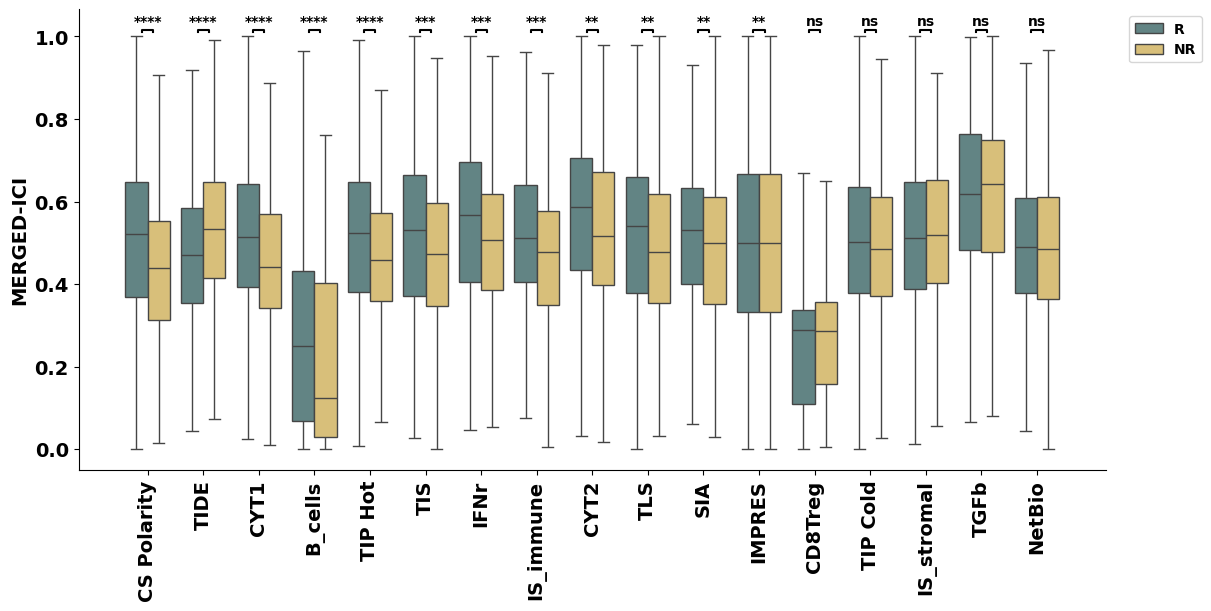

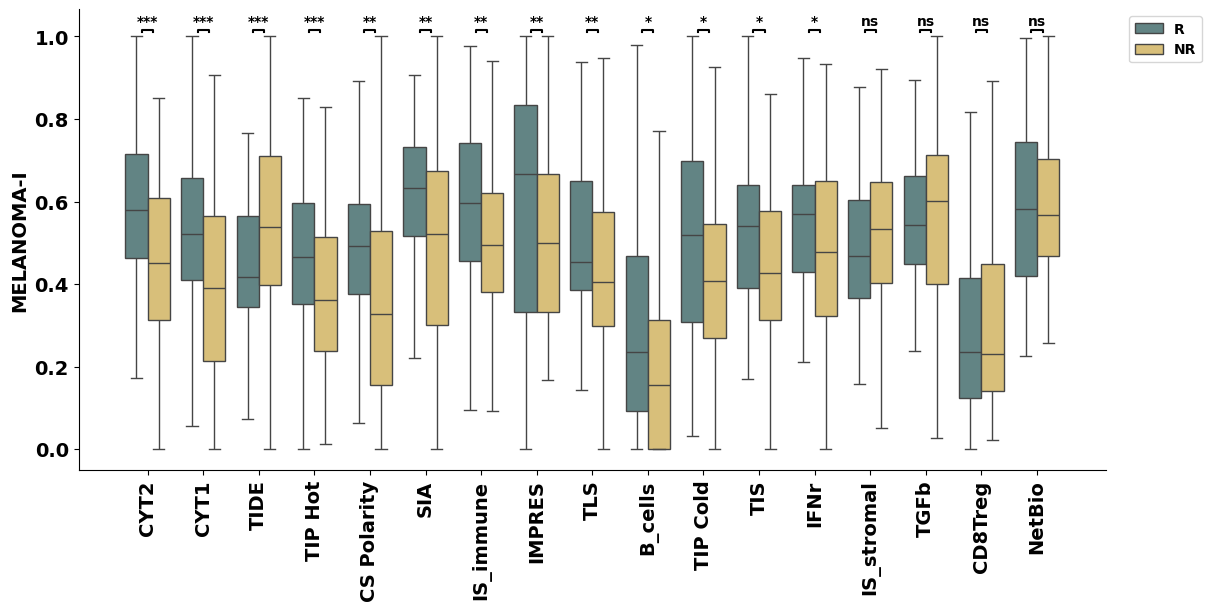

In [59]:
fig2_1, ax2_1 = plt.subplots(figsize=(12, 6), constrained_layout=True)
box_resp(ax = ax2_1, df = combined_data1, scores = score_cols, name = "MERGED-ICI", col_palette = ["#5C8A8A", "#E7C66B"])

fig2_2, ax2_2 = plt.subplots(figsize=(12, 6), constrained_layout=True)
box_resp(ax = ax2_2, df = melanoma_data1, scores = score_cols, name = "MELANOMA-I", col_palette = ["#5C8A8A", "#E7C66B"])



In [ ]:
data_list = [vath_data1, ccrcc_data1, unc108_data1, urothelial_met_data1, foy_nsclc_data1, ravi_data1, foy_hnscc_data1]
name_list = ['MELANOMA-II', 'ccRCC', 'UNC-108', 'UC-II', 'NIVOBIO', 'NSCLC-II', 'CLB-IHN']

## compute Mann-Whitney U test for individual cohorts
volcano_results = {}
for data, name in zip(data_list, name_list):
    volcano_results[name] = mwu_test(data, score_cols)
mwu_results_df = pd.concat(volcano_results, axis=0).reset_index()
mwu_results_df1 = mwu_results_df.rename(columns = {'level_0': 'cohort'})
mwu_results_df1 = mwu_results_df1.drop(columns = ['level_1'])
mwu_results_df1['neglog_p'] = -np.log10(mwu_results_df1['p_value'])

In [61]:
def volcano_mwu(ax, df = mwu_results_df1): 

    df['label'] = "(" + df['cohort'] + ", " + df['score']+")"
    sig_df = df[df['p_value'] < 0.1]
    nonsig_df = df[df['p_value'] >= 0.1]

    ## grey points for non-significant scores
    sns.scatterplot(data = nonsig_df, x = 'rho', y = 'neglog_p', color = 'lightgrey', marker = "^",
        s = 80, edgecolors = None, linewidth = 1, ax = ax)

    ## points for significant scores colored by cohort
    sns.scatterplot(data = sig_df, x = 'rho', y = 'neglog_p', hue = 'cohort', marker = "^",
                    s = 80, edgecolors = None, linewidth = 1, palette = "Set2", ax = ax)

    ## draw volcano plots
    for _, row in sig_df.iterrows():

        if row['score'] == "IS_immune" and row['cohort'] == "UNC-108":
            ax.annotate(row['score'], xy = (row['rho'], row['neglog_p']), xytext = (-70, -5),
                textcoords = 'offset points', ha = 'left', va = 'bottom', fontsize = 10, fontweight = 'bold')
        elif not (row['neglog_p'] < 2) & (row['rho'] < 0.27) & (row['rho'] > 0.13):
            ax.annotate(row['score'], xy = (row['rho'], row['neglog_p']), xytext = (5, -5),
                textcoords = 'offset points', ha = 'left', va = 'bottom', fontsize = 10, fontweight = 'bold')

    ## zoom in on specific region
    df_zoom = sig_df[(sig_df['neglog_p'] < 2) & (sig_df['rho'] < 0.27) & (sig_df['rho'] > 0.13)]

    # compute bounds + padding
    x_min, x_max = df_zoom['rho'].min(), df_zoom['rho'].max()
    y_min, y_max = df_zoom['neglog_p'].min(), df_zoom['neglog_p'].max()

    pad_x = (x_max - x_min)*0.1  # 10% padding on each side
    pad_y = (y_max - y_min)*0.1

    x1, x2 = x_min - pad_x, x_max + pad_x
    y1, y2 = y_min - pad_y, y_max + pad_y

    axins = inset_axes(ax,
                    width=2.5, 
                    height=2.5,
                    #loc='upper right',
                    bbox_to_anchor=(0.6, 1),
                    bbox_transform=ax.transAxes)

    # Plot the zoomed data
    sns.scatterplot(
        data = df,
            x    = 'rho',
            y    = 'neglog_p',
            hue  = 'cohort',
            marker = "^",
            s    = 80,
            palette = "Set2",
            ax   = axins,
            legend=False
        )

    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xlabel("")
    axins.set_ylabel("")
    axins.set_xticks([])
    axins.set_yticks([])

    # draw the “connector” lines between the inset and the main plot
    mark_inset(ax, axins,
            loc1=2, loc2=4,  linestyle="--",  
            fc="none", ec="grey", color = "grey")
    
    for _, row in df_zoom.iterrows():    # df_zoom the significant zoomed subset
        if row['label'] in ["(CLB-IHN, TLS)", "(CLB-IHN, CYT1)", "(CLB-IHN, EXH)"]:
            axins.annotate(
                row['score'],
                xy         = (row['rho'], row['neglog_p']),
                xytext     = (-15, 5),      
                textcoords = 'offset points',
                ha         = 'left',
                va         = 'bottom',
                fontsize   = 10,
                fontweight = 'bold',
                arrowprops = dict(
                    arrowstyle    = '->',
                    shrinkA       = 0.0,
                    shrinkB       = 0.2,
                    mutation_scale=10,
                    lw            = 0.8,
                    color         = 'black'
                )
            )
        ## adjust the annotation for specific points
        elif row['label'] == "(MELANOMA-II, CD8Treg)":
            axins.annotate(
                row['score'],
                xy         = (row['rho'], row['neglog_p']),
                xytext     = (-20, -20),           # offset in points
                textcoords = 'offset points',
                ha         = 'left',
                va         = 'bottom',
                fontsize   = 10,
                fontweight = 'bold',
                arrowprops = dict(
                    arrowstyle    = '->',
                    shrinkA       = 0.0,
                    shrinkB       = 0.2,
                    mutation_scale=10,
                    lw            = 0.8,
                    color         = 'black'
                )
            )
        elif row['label'] == "(CLB-IHN, IFNr)":
            axins.annotate(
                row['score'],
                xy         = (row['rho'], row['neglog_p']),
                xytext     = (5, -5),           # offset in points
                textcoords = 'offset points',
                ha         = 'left',
                va         = 'bottom',
                fontsize   = 9,
                fontweight = 'bold',
                arrowprops = dict(
                    arrowstyle    = '->',
                    shrinkA       = 0.0,
                    shrinkB       = 0.2,
                    mutation_scale=10,
                    lw            = 0.8,
                    color         = 'black'
                )
            )
        elif row['label'] == "(CLB-IHN, TIS)":
            axins.annotate(
                row['score'],
                xy         = (row['rho'], row['neglog_p']),
                xytext     = (10, 0),           # offset in points
                textcoords = 'offset points',
                ha         = 'left',
                va         = 'bottom',
                fontsize   = 9,
                fontweight = 'bold',
                arrowprops = dict(
                    arrowstyle    = '->',
                    shrinkA       = 0.0,
                    shrinkB       = 0.2,
                    mutation_scale=10,
                    lw            = 0.8,
                    color         = 'black'
                )
            )
        else:
            axins.annotate(
                row['score'],
                xy         = (row['rho'], row['neglog_p']),
                xytext     = (-10, -10),           # offset in points
                textcoords = 'offset points',
                ha         = 'left',
                va         = 'bottom',
                fontsize   = 10,
                fontweight = 'bold'
            )

    ax.axvline(0,linestyle='--', color='darkred')
    ax.axhline(-np.log10(0.1),linestyle='--', color='darkred')
    ax.set_xlabel(r"Spearman $\rho$", fontsize=12, fontweight='bold')
    ax.set_ylabel('-log10(p-value)', fontsize=12, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight='bold')
    ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')

    leg = ax.legend(frameon=True, title="Cohort", title_fontsize = 12,
                        prop={'weight':'bold', 'size':10}, loc = "upper left")
    leg.get_title().set_fontweight('bold')

    for spine in axins.spines.values():
        spine.set_edgecolor("grey")
        spine.set_linestyle("--")
        spine.set_linewidth(1.5)

    return ax



<Axes: xlabel='Spearman $\\rho$', ylabel='-log10(p-value)'>

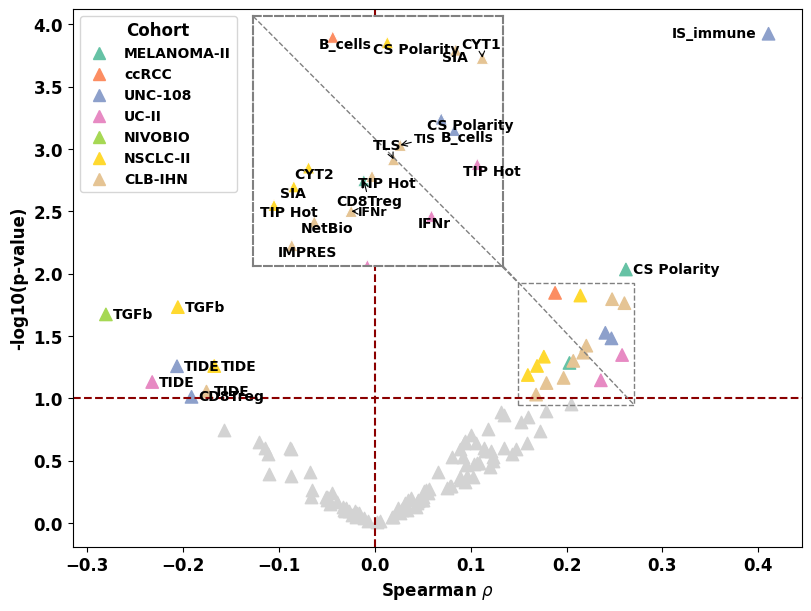

In [62]:
fig2_3, ax2_3 = plt.subplots(figsize=(8, 6), constrained_layout=True)

volcano_mwu(ax2_3)

In [ ]:
## compute logrank test results using TCGA sub-cohorts

def batch_logrank(df, time_col = "os_months", event_col = "os_event", group_col = "cancer"):
    score_list = score_cols
    results = []
    groups = df[group_col].unique()
    df1 = df.copy()
    
    for g in groups:
        df_group = df1[df1[group_col] == g]
        if df_group.shape[0] <= 100: ## if the group size is small, use median to divide
            df_group1 = divide_group(df_group, half = True)
        else:
            df_group1 = divide_group(df_group)
        for score in score_list:
            try:
                df_group2 = df_group1.dropna(subset = [score])
                score_group = score + "_group"
                df_group3 = df_group2[df_group2[score_group]!= "M"]
                cph = CoxPHFitter(penalizer=0.1)
                df_group3['indicator'] = (df_group3[score_group] == "L").astype(int)
                cph.fit(df_group3[['indicator', time_col, event_col]], duration_col=time_col, event_col=event_col)
                row = cph.summary.loc['indicator']
                lower_ci = np.exp(row['coef lower 95%'])
                upper_ci = np.exp(row['coef upper 95%'])

                results.append({
                    "cancer":     g,
                    "score": score,
                    'n_total':     len(df_group3),
                    'n_H':         df_group3['indicator'].sum(),
                    'n_L': len(df_group3) - df_group3['indicator'].sum(),
                    'n_events':    df_group2[event_col].sum(),
                    'coef':        row['coef'],
                    'HR':          row['exp(coef)'],
                    'HR_lower95':  lower_ci,
                    'HR_upper95':  upper_ci,
                    'p_value':     row['p']
                })
            except:
                continue
    
    return pd.DataFrame(results)

logrank_results = batch_logrank(tcga_os_data1)


In [ ]:
def volcano_logrank(ax, df = logrank_results):
    """ plot volcano plot for logrank test results."""
    df['neg_log_p'] = -np.log10(df['p_value'])
    df['label'] = "(" + df['cancer'] + ", " + df['score']+")"

    ### grey scatterplots for non-significant scores
    sns.scatterplot(
        data = df[df['p_value'] >= 0.15],
        x    = 'HR',
        y    = 'neg_log_p',
        color = "lightgrey", 
        s       = 80,
        legend = False,
        ax = ax,
        edgecolor=None
    )

    ### scatterplots for significant scores colored by cancer type
    sns.scatterplot(
        data = df[df['p_value'] < 0.15],
        x    = 'HR',
        y    = 'neg_log_p', palette = "husl",
        hue  = df['cancer'], 
        s       = 80,
        ax = ax,
        edgecolor=None
    )
    ax.axhline(-np.log10(0.1), color='darkred', ls='--')

    sig_df = df[df['p_value'] < 0.15]
    for _, row in sig_df.iterrows():
        ## manually annotate specific points
        if row['label'] in ["(SKCM, IS_immune)", "(SKCM, IS_stromal)"]:
            ax.annotate(
                row['score'],
                xy          = (row['HR'], row['neg_log_p']), 
                xytext      = (-40, 10),                  
                textcoords  = 'offset points',
                ha          = 'left',
                va          = 'bottom',
                fontsize    = 10,
                fontweight = "bold",
            arrowprops  = {
                'arrowstyle': '-',
                'lw': 0.8,     # line width
                'color': 'black',  # arrow color
                'shrinkA': 0.05,     # trims ends by 5%
            }
        )
        elif row['label'] == "(HNSC, TGFb)":
            ax.annotate(
                row['score'],
                xy          = (row['HR'], row['neg_log_p']), 
                xytext      = (-40, -20),                  
                textcoords  = 'offset points',
                ha          = 'left',
                va          = 'bottom',
                fontsize    = 10,
                fontweight = "bold",
            arrowprops  = {
                'arrowstyle': '-',
                'lw': 0.8,     # line width
                'color': 'black',  # arrow color
                'shrinkA': 0.05,     # trims ends by 5%
            }
        )
        elif row['label'] == "(SKCM, CYT2)":
            ax.annotate(
                row['score'],
                xy          = (row['HR'], row['neg_log_p']), 
                xytext      = (5, 5),                  
                textcoords  = 'offset points',
                ha          = 'left',
                va          = 'bottom',
                fontsize    = 10,
                fontweight = "bold",
            arrowprops  = {
                'arrowstyle': '-',
                'lw': 0.8,     # line width
                'color': 'black',  # arrow color
                'shrinkA': 0.05,     # trims ends by 5%
            }
        )
        elif row['cancer'] == "SKCM":
            ax.annotate(
                row['score'],
                xy          = (row['HR'], row['neg_log_p']), 
                xytext      = (-15, -10),                  
                textcoords  = 'offset points',
                ha          = 'left',
                va          = 'bottom',
                fontsize    = 10,
                fontweight = "bold",
            )
        elif row['label'] == "(BLCA, CYT2)":
            ax.annotate(
                row['score'],
                xy          = (row['HR'], row['neg_log_p']), 
                xytext      = (10, -10),                  
                textcoords  = 'offset points',
                ha          = 'left',
                va          = 'bottom',
                fontsize    = 10,
                fontweight = "bold",
            arrowprops  = {
                'arrowstyle': '-',
                'lw': 0.8,     # line width
                'color': 'black',  # arrow color
                'shrinkA': 0.05,     # trims ends by 5%
            }
        )
        else: ## annotate all other significant points
            ax.annotate(
                row['score'],
                xy          = (row['HR'], row['neg_log_p']), 
                xytext      = (0, 0),                  
                textcoords  = 'offset points',
                ha          = 'left',
                va          = 'bottom',
                fontsize    = 10,
                fontweight = "bold",
            )

    handles, labels = ax.get_legend_handles_labels()
    wanted = set(sig_df['cancer'].unique())
    filt   = [(h,l) for h,l in zip(handles,labels) if l in wanted]


    if filt:
        handles, labels = zip(*filt)
    else:
        handles, labels = [], []
    ax.set_xlabel('Hazard Ratio', fontsize=12, fontweight='bold')
    ax.set_ylabel('-log10(p-value)', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 5)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight='bold')
    ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')
    ax.set_title('')
    ax.set_ylim(0, 5)
    leg = ax.legend(handles = handles, labels = labels, frameon=True, title="Cohort", title_fontsize = 12,
                        prop={'weight':'bold', 'size':10}, loc = "upper left")
    leg.get_title().set_fontweight('bold')
    ax.axvline(1, color='darkred', ls='--')

    return ax


<Axes: xlabel='Hazard Ratio', ylabel='-log10(p-value)'>

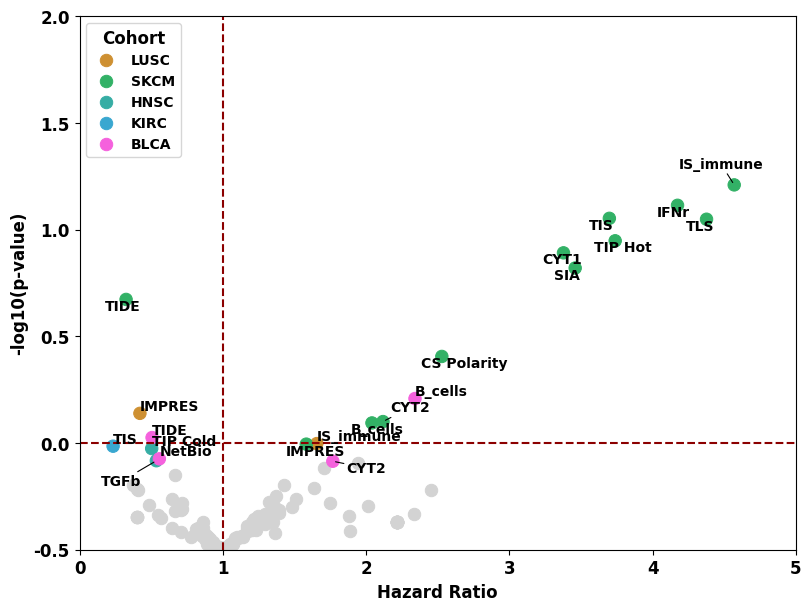

In [68]:
fig2_4, ax2_4 = plt.subplots(figsize=(8, 6), constrained_layout=True)

volcano_logrank(ax2_4)

#### Fig 3 (forest plot for MERGED-ICI and clinical covariates selection)

In [71]:
def HR_forest(ax, ax_table, cox_df, title, palette = ["#9DAEB6",  "#3D5C6F"]):
    """ plot forest plot for Cox regression results."""
    mask = cox_df.index.get_level_values(0) == cox_df.index.get_level_values(1)
    hr_df = cox_df[mask].copy()

    hr_df = hr_df.rename(columns={
        'coef':           'log(HR)',
        'coef lower 90%': 'lower90',
        'coef upper 90%': 'upper90',
    })
    ## sort by HR
    hr_df1 = hr_df.sort_values(by = 'log(HR)', ascending=True)
    ci_wide = hr_df1.pivot(index='score', columns='regression', values='c-index')
    scores  = list(i[0] for i in hr_df1.index.unique().tolist())
    y_base  = np.arange(len(scores))
    y_map   = dict(zip(scores, y_base))
    # set offsets for univariate and multivariate models
    offsets = {'univariate': +0.10, 'multivariate': -0.10}

    ## forest plot
    for model, grp in hr_df1.groupby('regression'):
        y_vals   = [y_map[s] + offsets[model] for s in grp['score']]
        hr       = grp['log(HR)']
        lo_err   = hr - grp['lower90']
        hi_err   = grp['upper90'] - hr

        ax.errorbar(
            hr, y_vals,
            xerr=[lo_err, hi_err],
            fmt='o',
            c = palette[0] if model == 'univariate' else palette[1],
            label=model.capitalize(),
            capsize=3
        )

    ax.axvline(0, color='lightgray', linestyle='--', lw=1)
    ax.set_yticks(y_base)
    ax.set_yticklabels(scores, fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight='bold')
    ax.set_xlabel("log(HR) (90% CI)", fontsize=12, fontweight='bold')
    ax.legend(frameon=False, title="", loc = "lower right", fontsize=10, prop={'weight':'bold'},bbox_to_anchor=(1.15, 0.95))

    ax_table.xaxis.tick_top()                 # move ticks & labels to top
    ax_table.tick_params(axis="x", length=0)  # no little tick-marks

    ## add table with c-index values
    ax_table.set_xticks([0, 1])
    ax_table.set_xticklabels(
        ["Uni", "Multi"],
        ha="center",
        va="bottom",   # or "top" if you want the text sitting above the tick line
        fontsize=12, fontweight='bold'
    )

    for score, y in y_map.items():
        uni   = ci_wide.loc[score,'univariate']
        multi = ci_wide.loc[score,'multivariate']
        ax_table.text(0, y, f"{uni:.4f}",   ha='center', va='center', fontsize=10, fontweight='bold')
        ax_table.text(1, y, f"{multi:.4f}", ha='center', va='center', fontsize=10, fontweight='bold')

    ax_table.set_xlim(-0.5, 1.5)
    ax_table.set_title("C-index", fontsize=12, fontweight='bold')

    for loc in ['top','right']:
        ax.spines[loc].set_visible(False)

    # table: drop all spines
    for spine in ax_table.spines.values():
        spine.set_visible(False)
    ax_table.set_facecolor('none')
    ax_table.patch.set_visible(False)

    return ax, ax_table


(<Axes: title={'center': 'MERGED-ICI (n = 605)'}, xlabel='log(HR) (90% CI)'>,
 <Axes: title={'center': 'C-index'}>)

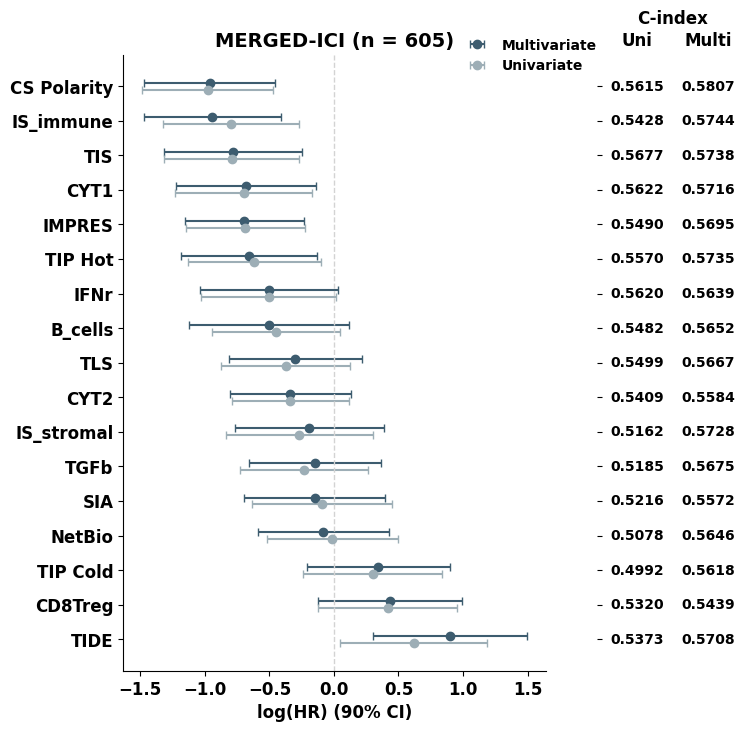

In [72]:
fig3_1, ax3_1 = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,1], 'wspace':0.2},figsize=(8, 8))
HR_forest(ax3_1[0], ax3_1[1], cox_combined_df, "MERGED-ICI (n = 605)")

In [73]:
def survival_stack_bar(ax, df, category_col, cancer_type, event_col = "os_event", palette = ["#547AC0", "#898988"], legend = False):
    """ stacked bar plot for survival status by category."""
    df1 = df.dropna(subset = [category_col, event_col])
    # rename the category column
    if category_col == "treatment":
        df1[category_col] = df1[category_col].map({"ctla4": 'CTLA-4', "pd1/pdl1": 'PD-1/PD-L1'})
    elif category_col == "gender" and cancer_type == "TCGA":
        df1[category_col] = df1[category_col].map({"male": 'M', "female": 'F'})

    df1['survival_status'] = df1[event_col].map({1: 'Dead', 0: 'Alive'})
    counts = pd.crosstab(df1[category_col], df1['survival_status'])
    props  = counts.div(counts.sum(axis=1), axis=0)
    table   = counts.values 
    # perform Fisher's exact test
    _, p  = fisher_exact(table)
    if p < 0.001:
        star = '****'
    elif p < 0.01:
        star = '***'
    elif p < 0.05:
        star = '**'
    elif p < 0.1:
        star = '*'
    else:
        star = 'ns'
    # create a bar plot
    ax = props.plot(kind='bar',stacked=True,color=palette,legend = False,edgecolor='black',ax=ax)
    # add the counts on top of the bars
    for i, (_, row) in enumerate(counts.iterrows()):
        cum = 0
        total = row.sum()
        for status in counts.columns:
            value = row[status]
            if value == 0:
                continue
            percentage = value/total
            y = cum + percentage/2
            ax.text(
                i, y,
                str(value),
                ha='center', va='center',
                color='black',
                fontsize=12,
                fontweight='bold'
            )
            cum += percentage

    x1, x2 = 0, 1
    offset = 0.03
    y_line = 1 + offset
    # draw the line below the stars
    ax.plot([x1, x2],[y_line, y_line],lw=1.5,c='black')

    ax.text((x1 + x2) / 2,y_line + offset/2,star,ha='center',va='bottom',fontsize=12)

    ax.set_xlabel("")
    ax.set_ylabel(f"{cancer_type} {category_col.upper()}", weight = 'bold', size = 12)
    ax.set_title("")
    ax.set_ylim(0,1 + 2*offset)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, weight = 'bold', size = 12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticklabels(ax.get_yticklabels(), weight = 'bold', size = 12)
    if legend:
        leg = ax.legend(title="Survival Status", bbox_to_anchor=(1.02, 1), frameon=True, fontsize = 10, 
                  title_fontsize = 12, prop = {'weight':'bold'})
        leg.get_title().set_fontweight('bold')
        
    return ax


In [76]:
def violin_age(ax, df, cancer_type, resp_col = "os_event"):
    """ Violin plot for age distribution by survival status."""
    df1 = df.dropna(subset = ["age", resp_col])
    df1['survival_status'] = df1[resp_col].map({1: 'Dead', 0: 'Alive'})
    # plot the violin plot
    sns.violinplot(ax = ax,x = 'survival_status',y  = 'age', data = df1, split= False,
                   scale= 'width', color = "grey", dodge = True, order = ['Alive','Dead'])

    # add the significance annotation
    annotator = Annotator(ax, [("Alive", "Dead")], data = df1, x = "survival_status", y = "age", 
                          order = ['Alive','Dead'])
    annotator.configure(test = "Mann-Whitney", line_height = 0, line_offset = 0.3, 
                        text_format = "star", loc = 'inside', pvalue_thresholds=[
        [0.001, '****'],
        [0.01,  '***' ],
        [0.05,  '**'  ],
        [0.1,   '*'   ],
        [1,     'ns'  ]])
    
    annotator.apply_and_annotate()
    ax.set_ylabel(f"{cancer_type} AGE", weight = 'bold', size = 12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, weight = 'bold', size = 12)
    ax.set_xlabel("")
    ax.set_yticklabels(ax.get_yticklabels(), weight = 'bold', size = 12)
    return ax

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       *: 5.00e-02 < p <= 1.00e-01
      **: 1.00e-02 < p <= 5.00e-02
     ***: 1.00e-03 < p <= 1.00e-02
    ****: p <= 1.00e-03

Alive vs. Dead: Mann-Whitney-Wilcoxon test two-sided, P_val:2.296e-03 U_stat=5.356e+04


<Axes: ylabel='TCGA AGE'>

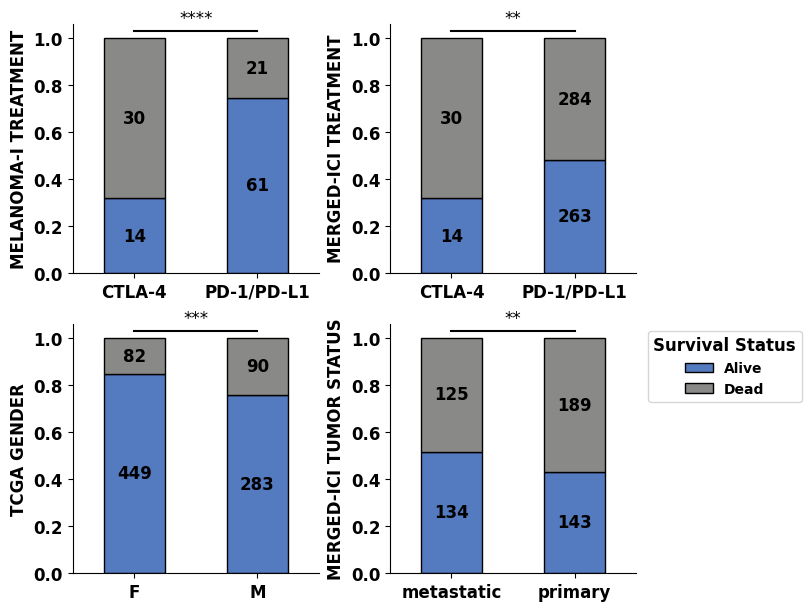

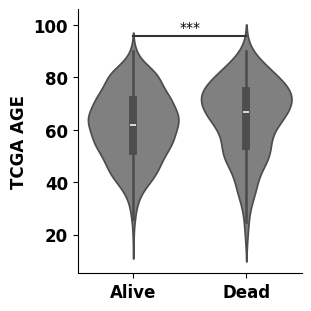

In [ ]:
combined_data1['tumor status'] = combined_data1['tumor type']
fig3_2, ax3_2 = plt.subplots(2,2, figsize=(8, 6), constrained_layout=True)
survival_stack_bar(ax3_2[0,0], melanoma_data1, "treatment", "MELANOMA-I")
survival_stack_bar(ax3_2[0,1], combined_data1, "treatment", "MERGED-ICI")
survival_stack_bar(ax3_2[1,1], combined_data1, "tumor status", "MERGED-ICI", legend = True)
survival_stack_bar(ax3_2[1,0], tcga_os_data1, "gender", "TCGA")

fig3_3, ax3_3 = plt.subplots(figsize=(3, 3), constrained_layout=True)
violin_age(ax3_3, tcga_os_data1, cancer_type = "TCGA", resp_col = "os_event")


#### Fig 4 (forest plots for MELANOMA-I and TCGA)

(<Axes: title={'center': 'TCGA (n = 904)'}, xlabel='log(HR) (90% CI)'>,
 <Axes: title={'center': 'C-index'}>)

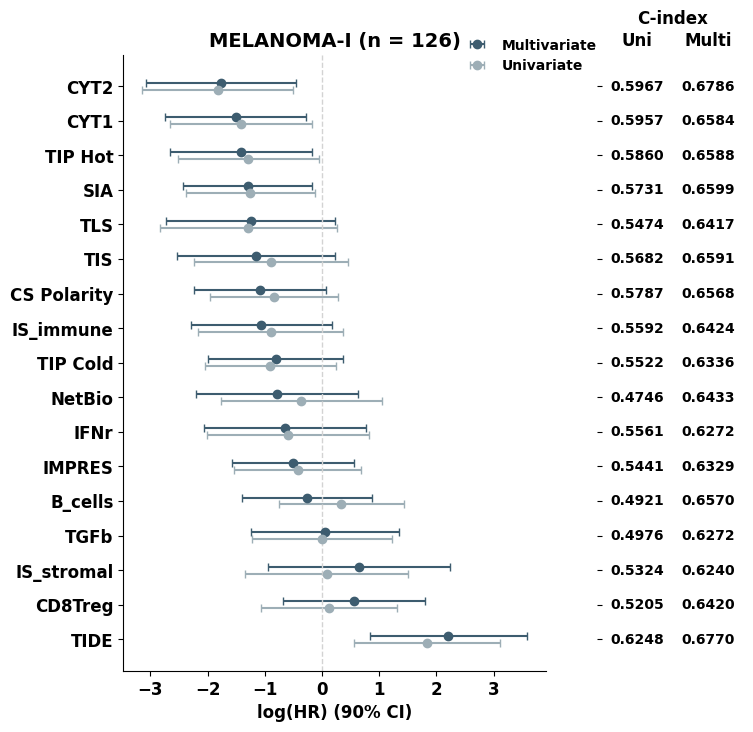

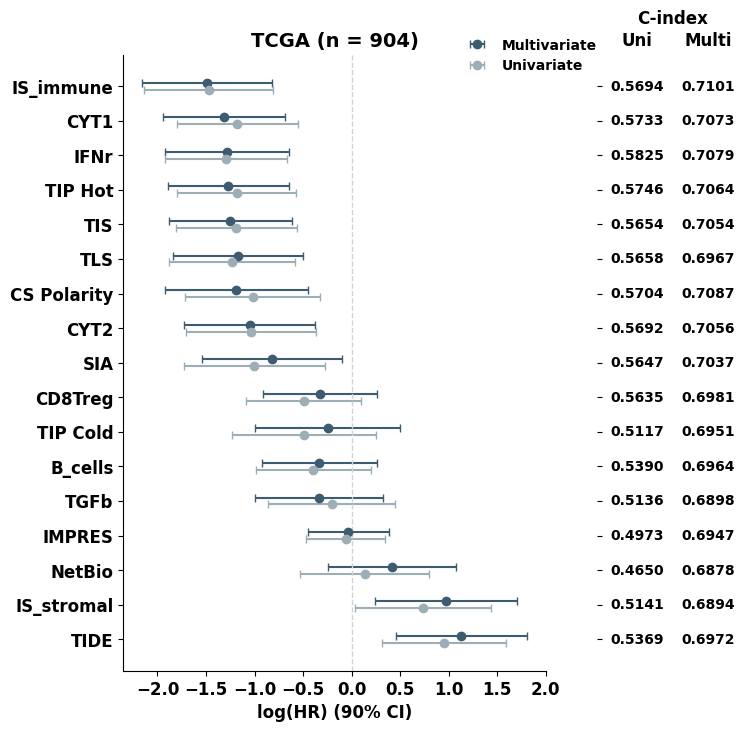

In [78]:
fig4_1, ax4_1 = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,1], 'wspace':0.2}, figsize=(8, 8))
HR_forest(ax4_1[0], ax4_1[1], cox_melanoma_df, "MELANOMA-I (n = 126)")

fig4_2, ax4_2 = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,1], 'wspace':0.2}, figsize=(8, 8))
HR_forest(ax4_2[0], ax4_2[1], cox_tcga_os_df, "TCGA (n = 904)")

#### Fig. 5 (K-M survival curves for optimal or robust scores)

In [80]:
def km_survival(ax, df, time, delta, score_list, ylab, custom_palette = ["#547AC0", "#898988"], sig = False):#["#3D5C6F", "#9DAEB6"]dark blue: "#6699CC"
    """ Plot Kaplan-Meier survival curves for high and low score groups."""
    df1 = df[~df[delta].isna()]
    df1 = df1[~df1[time].isna()]
    kmf_H = KaplanMeierFitter()
    kmf_L = KaplanMeierFitter()

    n_score = len(score_list)
    ncol = 4
    nrow = (n_score+ncol-1)//ncol
    
    score_col = score_list+"_group"
    # Fit the model for each group
    kmf_H.fit(durations=df1[df1[score_col] == 'H'][time], event_observed=df1[df1[score_col] == 'H'][delta], label='H')
    kmf_L.fit(durations=df1[df1[score_col] == 'L'][time], event_observed=df1[df1[score_col] == 'L'][delta], label='L')

    n_H = df1[df1[score_col] == 'H'].shape[0]
    n_L = df1[df1[score_col] == 'L'].shape[0]
        
    # Plot the survival curves
    kmf_H.plot_survival_function(show_censors = True, color=custom_palette[0], ci_show=False, ax = ax)
    kmf_L.plot_survival_function(show_censors = True, color=custom_palette[1], ci_show=False, ax = ax)

    # perform log-rank test to the high and low groups
    df1[time] = pd.to_numeric(df1[time], errors='coerce')
    df1[delta] = pd.to_numeric(df1[delta], errors='coerce')
    results = logrank_test(df1[df1[score_col] == 'H'][time], df1[df1[score_col] == 'L'][time], 
                        event_observed_A=df1[df1[score_col] == 'H'][delta], event_observed_B=df1[df1[score_col] == 'L'][delta])

    # Add title and labels
    n = df1.shape[0]
    ax.set_title("")
    ax.set_xlabel("OS Months", fontsize = 12, fontweight = 'bold')
    ax.set_ylim(0,1.1)
    xticks = ax.get_xticks()
    xticks_rounded = np.round(xticks, decimals=0)
    ax.set_xticklabels([f'{tick:.0f}' for tick in xticks_rounded], weight = 'bold', size = 14)
    ax.set_yticklabels(["0.0","0.2", "0.4", "0.6", "0.8", "1.0"] ,weight = 'bold', size = 14)

    ax.set_ylabel(score_list, fontsize = 12, fontweight = 'bold')
    if sig:
        ax.text(0.6, 0.95, f'P = {results.p_value:.4f}\nn = {n}\nn_H = {n_L}\nn_L = {n_H}', transform = ax.transAxes, 
            fontsize = 10, verticalalignment = 'top', horizontalalignment = 'left', fontweight = "bold", color='darkred',
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3', linewidth=1.5))
    else:
        ax.text(0.6, 0.95, f'P = {results.p_value:.4f}\nn = {n}\nn_H = {n_L}\nn_L = {n_H}', transform = ax.transAxes, 
            fontsize = 10, verticalalignment = 'top', horizontalalignment = 'left', fontweight = "bold")

    ax.set_title(ylab, fontweight = 'bold', fontsize = 14)
    ax.legend(frameon=False, title="", title_fontsize = 12,
                        prop={'weight':'bold', 'size':10}, loc = "lower left")

    return ax

<Axes: title={'center': 'NIVOBIO'}, xlabel='OS Months', ylabel='TGFb'>

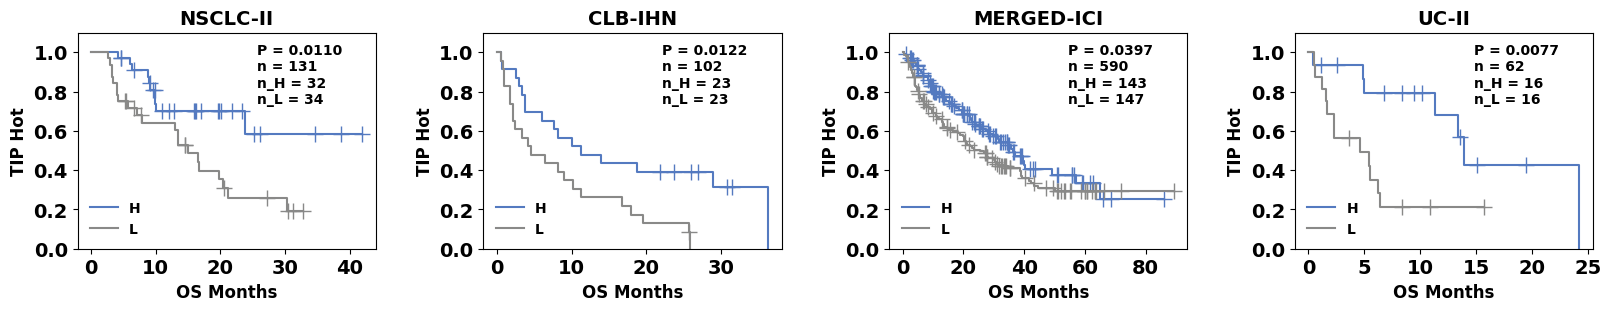

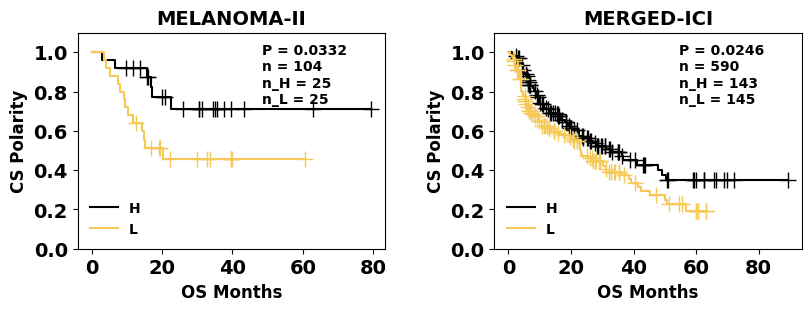

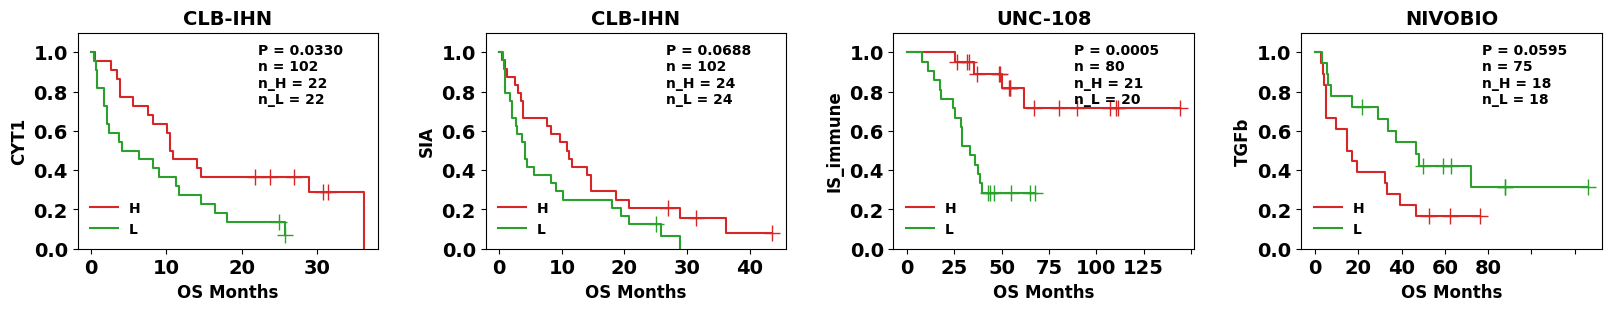

In [81]:
vath_data1['os_months'] = vath_data1['os_days']/30

fig5_1, ax5_1 = plt.subplots(1,4, figsize=(16, 3), constrained_layout=True, gridspec_kw={'wspace': 0.1})
km_survival(ax5_1[0], ravi_data1, "os_months", "os_event", 'TIP Hot', "NSCLC-II")
km_survival(ax5_1[1], foy_hnscc_data1, "OS_month", "OS_status", 'TIP Hot', "CLB-IHN")
km_survival(ax5_1[2], combined_data1, "os_months", "os_event", 'TIP Hot', "MERGED-ICI")
km_survival(ax5_1[3], urothelial_met_data1, "os_months", "os_event", 'TIP Hot', "UC-II")

fig5_2, ax5_2 = plt.subplots(1,2, figsize=(8, 3), constrained_layout=True, gridspec_kw={'wspace': 0.1})
km_survival(ax5_2[0], vath_data1, "os_months", "os_status", 'CS Polarity', "MELANOMA-II", custom_palette=["black", "#F6C957"])
km_survival(ax5_2[1], combined_data1, "os_months", "os_event", 'CS Polarity', "MERGED-ICI", custom_palette=["black", "#F6C957"])

fig5_3, ax5_3 = plt.subplots(1,4, figsize=(16, 3), constrained_layout=True, gridspec_kw={'wspace': 0.1})

km_survival(ax5_3[0], foy_hnscc_data1, "OS_month", "OS_status", 'CYT1', "CLB-IHN", custom_palette=["#D62728", "#2CA02C"])
km_survival(ax5_3[1], foy_hnscc_data1, "OS_month", "OS_status", 'SIA', "CLB-IHN", custom_palette=["#D62728", "#2CA02C"])
km_survival(ax5_3[2], unc108_data1, "os_months", "os_event", 'IS_immune', "UNC-108", custom_palette=["#D62728", "#2CA02C"])
km_survival(ax5_3[3], foy_nsclc_data1, "OS_month", "OS_event", 'TGFb', "NIVOBIO", custom_palette=["#D62728", "#2CA02C"])

#### Fig. 6 (Batch effect correction)

In [ ]:
## load data for batch correction
melanoma_gene = pd.read_csv("data/melanoma_gene.csv", index_col=0)
combined_gene = pd.read_csv("data/combined_gene.csv", index_col=0)
tcga_gene = pd.read_csv("data/tcga_gene.csv", index_col=0)

## perform batch correction using ComBat
melanoma_pd1_labels = ['Hugo et al. (n=27)']*27 + ['Cui et al. (n=55)']*55
melanoma_ctla4_labels = ['Van Allen et al. (n=38)']*38 + ['Snyder et al. (n=6)']*6
melanoma_labels = melanoma_pd1_labels + melanoma_ctla4_labels
melanoma_gene_combat = batch_correction(melanoma_gene, melanoma_labels)

combined_added_labels = ['ccRCC (n=171)']*171 + ['UC-II (n=62)']*62 + ['UNC-108 (n=89)']*89 + ['INSPIRE (n=21)']*21 + ['NSCLC-II (n=136)']*136
combined_labels = [f'MELANOMA-I (n=126)']*126 + combined_added_labels
combined_gene_combat = batch_correction(combined_gene, combined_labels)

tcga_os_combat = batch_correction(tcga_gene, tcga_os_clin['batch'])


In [82]:
def batch_plot(ax, df, batch, name, xlim = [-100,100], legend = None):
    """ Plot PCA for input data."""
    X1 = df.T.values
    n_pc = len(set(batch))
    batch = np.array(batch)

    # PCA for original data
    pca = PCA(n_components=n_pc, random_state = 123)
    X1_pca = np.asarray(pca.fit_transform(X1))
    ## compute the mean entropy
    entropy = compute_entropy(df, batch)

    for lab in np.unique(batch):
        idx = batch == lab
        ax.scatter(X1_pca[idx, 0],
                        X1_pca[idx, 1],
                        label=lab, alpha=0.7)

    ax.set_title(name, fontsize=14, fontweight='bold')
    cohort, _ = name.split(" ")
    if legend:
        leg = ax.legend(frameon=False, title="", title_fontsize = 12,
                        prop={'weight':'bold', 'size':10}, bbox_to_anchor=(1.02, 1))
        leg.get_title().set_fontweight('bold')
    ax.set_xlabel('PC1', fontsize=12, fontweight='bold')
    ax.set_ylabel('PC2', fontsize=12, fontweight='bold')
    ticks = ax.get_yticks()
    ax.set_yticklabels([f'{tick:.0f}' for tick in ticks], fontsize=12, fontweight='bold')

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight='bold')
    ax.text(0.05, 0.95, f'Mean Entropy: {entropy:.4f}', transform=ax.transAxes, va="top", size=12, fontweight='bold')

    return ax

<Axes: title={'center': 'TCGA After'}, xlabel='PC1', ylabel='PC2'>

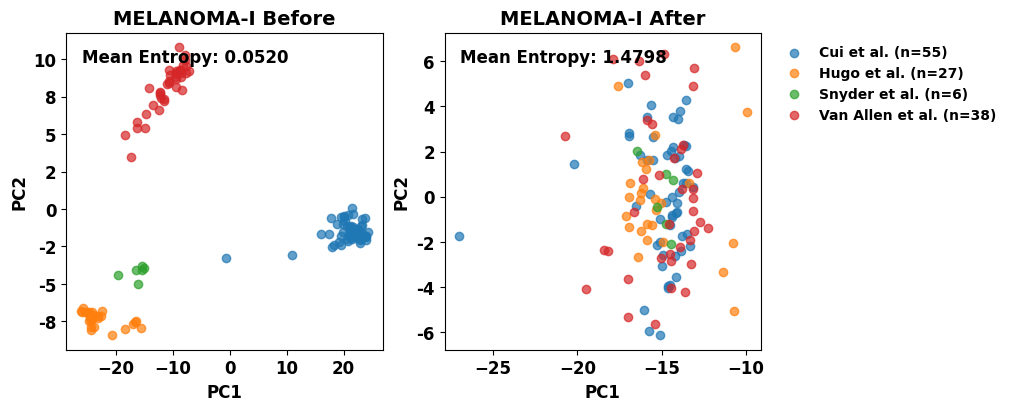

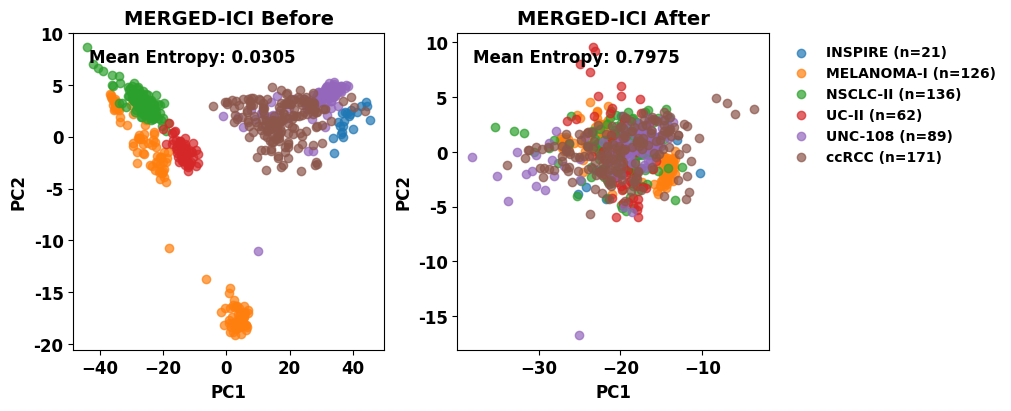

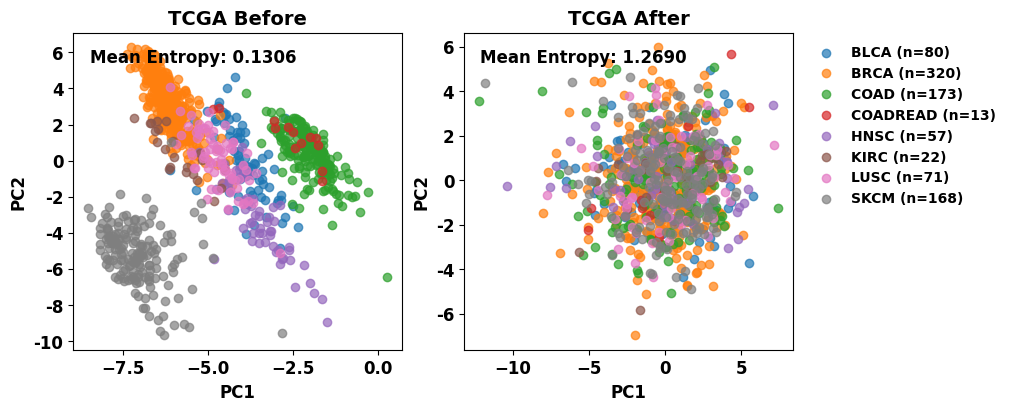

In [83]:
### melanoma-I

fig1_1, ax1_1 = plt.subplots(1,2, figsize=(10, 4), constrained_layout=True)
batch_plot(ax1_1[0], melanoma_gene, melanoma_labels, name = "MELANOMA-I Before", xlim = [-10,10])
batch_plot(ax1_1[1], melanoma_gene_combat, melanoma_labels, name = "MELANOMA-I After", xlim = [-10,10], legend = True)

### COM-ICI
fig1_3, ax1_3 = plt.subplots(1,2, figsize=(10, 4), constrained_layout=True)
batch_plot(ax1_3[0], combined_gene, combined_labels, name = "MERGED-ICI Before")
batch_plot(ax1_3[1], combined_gene_combat, combined_labels, name = "MERGED-ICI After", legend = True)

### TCGA
fig1_2, ax1_2 = plt.subplots(1,2, figsize=(10, 4), constrained_layout=True)
batch_plot(ax1_2[0], tcga_gene, tcga_os_clin['batch'], name = "TCGA Before", xlim = [-50,50])
batch_plot(ax1_2[1], tcga_os_combat, tcga_os_clin['batch'], name = "TCGA After", xlim = [-50,50], legend = True)